# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import json

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# For Local Machine
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

# # For Udacity Workspace
# !pip -q install ./python
# from unityagents import UnityEnvironment
# env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 10):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         print(actions)
#         print(rewards)
#         print(dones)
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
# #     print(rewards)
# #     print(dones)

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
#MADDPG
def seeding(seed=10):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, full_state_size, full_action_size, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of both agents states
            action_size (int): Dimension of both agents actions
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, full_state, full_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(full_state))
        x = torch.cat((xs, full_action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)


class MADDPG(object):
    '''The main class that defines and trains all the agents'''
    def __init__(self, state_size, action_size, num_agents):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.whole_action_dim = self.action_size*self.num_agents
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE) # Replay memory
        self.maddpg_agents = [DDPG(state_size, action_size, num_agents), DDPG(state_size, action_size, num_agents)] #create agents
        self.episodes_before_training = EPISODES_BEFORE_TRAINING
        
    def reset(self):
        for agent in self.maddpg_agents:
            agent.reset()

    def step(self, i_episode, states, actions, rewards, next_states, dones):
        #for stepping maddpg
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # index 0 is for agent 0 and index 1 is for agent 1
        full_states = np.reshape(states, newshape=(-1))
        full_next_states = np.reshape(next_states, newshape=(-1))
        
        # Save experience / reward
        self.memory.add(full_states, states, actions, rewards, full_next_states, next_states, dones)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and i_episode > self.episodes_before_training:
            for _ in range(NUM_LEARN_STEPS_PER_ENV_STEP): #learn multiple times at every step
                for agent_no in range(self.num_agents):
                    samples = self.memory.sample()
                    self.learn(samples, agent_no, GAMMA)
                self.soft_update_all()

    def soft_update_all(self):
        #soft update all the agents            
        for agent in self.maddpg_agents:
            agent.soft_update_all()
    
    def learn(self, samples, agent_no, gamma):
        #for learning MADDPG
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        critic_full_next_actions = torch.zeros(states.shape[:2] + (self.action_size,), dtype=torch.float, device=DEVICE)
        for agent_id, agent in enumerate(self.maddpg_agents):
            agent_next_state = next_states[:,agent_id,:]
            critic_full_next_actions[:,agent_id,:] = agent.actor_target.forward(agent_next_state)
        critic_full_next_actions = critic_full_next_actions.view(-1, self.whole_action_dim)
        
        agent = self.maddpg_agents[agent_no]
        agent_state = states[:,agent_no,:]
        actor_full_actions = actions.clone() #create a deep copy
        actor_full_actions[:,agent_no,:] = agent.actor_local.forward(agent_state)
        actor_full_actions = actor_full_actions.view(-1, self.whole_action_dim)
                
        full_actions = actions.view(-1,self.whole_action_dim)
        
        agent_rewards = rewards[:,agent_no].view(-1,1) #gives wrong result without doing this
        agent_dones = dones[:,agent_no].view(-1,1) #gives wrong result without doing this
        experiences = (full_states, actor_full_actions, full_actions, agent_rewards, \
                       agent_dones, full_next_states, critic_full_next_actions)
        agent.learn(experiences, gamma)

        #params_delete = list(agent.actor_local.parameters())
        #print(len(params_delete))
        #print(params_delete[2].size())
        #print(params_delete[0][0:3,0:3])
        

    def learn_double_ddpg(self, samples, agent_no, gamma):
        #for learning double ddpg
        full_states, states, actions, rewards, full_next_states, next_states, dones = samples
        
        temp_agent_no = np.random.randint(0,2) #to decide which agent's experience to use
        strt = temp_agent_no * self.state_size
        stp = strt + self.state_size
        full_states = full_states[:, strt:stp]
        states = states[:,temp_agent_no]
        actions = actions[:,temp_agent_no]
        rewards = rewards[:,temp_agent_no]
        full_next_states = full_next_states[:,strt:stp]
        next_states = next_states[:,temp_agent_no]
        dones = dones[:,temp_agent_no]
        
        
        agent = self.maddpg_agents[agent_no]
        critic_full_next_actions = agent.actor_target.forward(next_states)
        actor_full_actions = agent.actor_local.forward(states)
        full_actions = actions
        
        experiences = (full_states, actor_full_actions, full_actions, rewards, \
                        dones, full_next_states, critic_full_next_actions)
        
        agent.learn(experiences, gamma)

            
    def act(self, full_states, i_episode, add_noise=True):
        # all actions between -1 and 1
        actions = []
        for agent_id, agent in enumerate(self.maddpg_agents):
            action = agent.act(np.reshape(full_states[agent_id,:], newshape=(1,-1)), i_episode, add_noise)
            action = np.reshape(action, newshape=(1,-1))            
            actions.append(action)
        actions = np.concatenate(actions, axis=0)
        return actions

    def save_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_local_' + str(agent_id) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_local_' + str(agent_id) + '.pth')

    def load_maddpg(self):
        for agent_id, agent in enumerate(self.maddpg_agents):
            #Since the model is trained on gpu, need to load all gpu tensors to cpu:
            agent.actor_local.load_state_dict(torch.load('checkpoint_actor_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))
            agent.critic_local.load_state_dict(torch.load('checkpoint_critic_local_' + str(agent_id) + '.pth', map_location=lambda storage, loc: storage))

            agent.noise_scale = NOISE_END #initialize to the final epsilon value upon training


class DDPG(object):
    """Interacts with and learns from the environment.
    There are two agents and the observations of each agent has 24 dimensions. Each agent's action has 2 dimensions.
    Will use two separate actor networks (one for each agent using each agent's observations only and output that agent's action).
    The critic for each agents gets to see the actions and observations of all agents. """
    
    def __init__(self, state_size, action_size, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state for each agent
            action_size (int): dimension of each action for each agent
        """
        self.state_size = state_size
        self.action_size = action_size        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size).to(DEVICE)
        self.actor_target = Actor(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        self.noise = OUNoise(action_size) #single agent only
        self.noise_scale = NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def act(self, states, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        if i_episode > EPISODES_BEFORE_TRAINING and self.noise_scale > NOISE_END:
            #self.noise_scale *= NOISE_REDUCTION
            self.noise_scale = NOISE_REDUCTION**(i_episode-EPISODES_BEFORE_TRAINING)
        #else keep the previous value
        
        if not add_noise:
            self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise
        #actions += self.noise_scale*self.add_noise2()
        actions += self.noise_scale*self.noise.sample()
        
        return np.clip(actions, -1, 1)

    def add_noise2(self):
        noise = np.random.randn(1,self.action_size)
        return noise
        
        
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        #for MADDPG
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get Q values from target models
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)
        # Compute Q targets for current states (y_i)
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        # Compute critic loss
        Q_expected = self.critic_local(full_states, full_actions)
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target) #target=Q_targets.detach() #not necessary to detach
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() #-ve b'cse we want to do gradient ascent
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

        
        
    def soft_update_all(self):
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)


   
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise(object):
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
#actions += self.noise.sample()
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["full_state", "state", "action", "reward", \
                                                                "full_next_state", "next_state", "done"])

    def add(self, full_state, state, action, reward, full_next_state, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(full_state, state, action, reward, full_next_state, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(DEVICE)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        full_next_states = torch.from_numpy(np.array([e.full_next_state for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (full_states, states, actions, rewards, full_next_states, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [7]:
#Constants
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay
#to decay exploration as it learns
NOISE_START=1.0
NOISE_END=0.5 #0.15
NOISE_REDUCTION=0.999
EPISODES_BEFORE_TRAINING = 300
NUM_LEARN_STEPS_PER_ENV_STEP = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seeding(seed=2)
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)
###MADDPG_obj.load_maddpg() #load the local network weights


#Training
def MADDPG_Training(n_episodes=4000, t_max=1000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG)
        num_steps = 0
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG)
            MADDPG_obj.step(i_episode, states, actions, rewards, next_states, dones) #train the MADDPG_obj           
            states = next_states                               # roll over states to next time step
            num_steps += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(i_episode, np.mean(scores_deque), np.max(scores)))
        print('Epsilon: {}, Memory size: {} and Num Steps: {}'.format(MADDPG_obj.maddpg_agents[0].noise_scale, len(MADDPG_obj.memory), num_steps))
        
        if i_episode % 500 == 0:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            MADDPG_obj.save_maddpg()
            print('Saved Model: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list, scores_list_100_avg

Episode 1	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 15 and Num Steps: 15
Episode 2	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 29 and Num Steps: 14
Episode 3	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 43 and Num Steps: 14
Episode 4	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 57 and Num Steps: 14
Episode 5	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 71 and Num Steps: 14
Episode 6	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 86 and Num Steps: 15
Episode 7	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 100 and Num Steps: 14
Episode 8	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 114 and Num Steps: 14
Episode 9	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 128 and Num Steps: 14
Episode 10	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 142 and Num Steps: 14
Episode 11	Average Score:

Episode 84	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1327 and Num Steps: 16
Episode 85	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1341 and Num Steps: 14
Episode 86	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1355 and Num Steps: 14
Episode 87	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1369 and Num Steps: 14
Episode 88	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1383 and Num Steps: 14
Episode 89	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1398 and Num Steps: 15
Episode 90	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1412 and Num Steps: 14
Episode 91	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1426 and Num Steps: 14
Episode 92	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1444 and Num Steps: 18
Episode 93	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 1458 and Num Steps: 14


Episode 167	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 2600 and Num Steps: 14
Episode 168	Average Score: 0.00	Current Score: 0.0
Epsilon: 1.0, Memory size: 2614 and Num Steps: 14
Episode 169	Average Score: 0.01	Current Score: 0.10000000149011612
Epsilon: 1.0, Memory size: 2647 and Num Steps: 33
Episode 170	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2661 and Num Steps: 14
Episode 171	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2675 and Num Steps: 14
Episode 172	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2690 and Num Steps: 15
Episode 173	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2716 and Num Steps: 26
Episode 174	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2730 and Num Steps: 14
Episode 175	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 2745 and Num Steps: 15
Episode 176	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory siz

Episode 250	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 3920 and Num Steps: 16
Episode 251	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 3934 and Num Steps: 14
Episode 252	Average Score: 0.01	Current Score: 0.10000000149011612
Epsilon: 1.0, Memory size: 4004 and Num Steps: 70
Episode 253	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4018 and Num Steps: 14
Episode 254	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4032 and Num Steps: 14
Episode 255	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4046 and Num Steps: 14
Episode 256	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4061 and Num Steps: 15
Episode 257	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4075 and Num Steps: 14
Episode 258	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory size: 4089 and Num Steps: 14
Episode 259	Average Score: 0.01	Current Score: 0.0
Epsilon: 1.0, Memory siz

Episode 328	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9723747443770956, Memory size: 5168 and Num Steps: 14
Episode 329	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9714023696327184, Memory size: 5182 and Num Steps: 14
Episode 330	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9704309672630858, Memory size: 5196 and Num Steps: 14
Episode 331	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9694605362958226, Memory size: 5210 and Num Steps: 14
Episode 332	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9684910757595268, Memory size: 5225 and Num Steps: 15
Episode 333	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9675225846837673, Memory size: 5239 and Num Steps: 14
Episode 334	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9665550620990835, Memory size: 5253 and Num Steps: 14
Episode 335	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9655885070369844, Memory size: 5267 and Num Steps: 14
Episode 336	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9646229185

Episode 398	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9066044494080757, Memory size: 6244 and Num Steps: 15
Episode 399	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9056978449586677, Memory size: 6259 and Num Steps: 15
Episode 400	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9047921471137089, Memory size: 6273 and Num Steps: 14
Episode 401	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9038873549665952, Memory size: 6289 and Num Steps: 16
Episode 402	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9029834676116286, Memory size: 6303 and Num Steps: 14
Episode 403	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.902080484144017, Memory size: 6319 and Num Steps: 16
Episode 404	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.901178403659873, Memory size: 6333 and Num Steps: 14
Episode 405	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.9002772252562131, Memory size: 6347 and Num Steps: 14
Episode 406	Average Score: 0.00	Current Score: 0.0
Epsilon: 0.899376948030

Episode 468	Average Score: 0.01	Current Score: 0.0
Epsilon: 0.8452827805735026, Memory size: 7408 and Num Steps: 14
Episode 469	Average Score: 0.01	Current Score: 0.0
Epsilon: 0.8444374977929291, Memory size: 7422 and Num Steps: 14
Episode 470	Average Score: 0.01	Current Score: 0.0
Epsilon: 0.8435930602951361, Memory size: 7436 and Num Steps: 14
Episode 471	Average Score: 0.01	Current Score: 0.0
Epsilon: 0.842749467234841, Memory size: 7451 and Num Steps: 15
Episode 472	Average Score: 0.01	Current Score: 0.0
Epsilon: 0.8419067177676062, Memory size: 7465 and Num Steps: 14
Episode 473	Average Score: 0.02	Current Score: 0.10000000149011612
Epsilon: 0.8410648110498385, Memory size: 7495 and Num Steps: 30
Episode 474	Average Score: 0.02	Current Score: 0.0
Epsilon: 0.8402237462387887, Memory size: 7509 and Num Steps: 14
Episode 475	Average Score: 0.02	Current Score: 0.0
Epsilon: 0.8393835224925499, Memory size: 7524 and Num Steps: 15
Episode 476	Average Score: 0.01	Current Score: 0.0
Epsilo

Episode 536	Average Score: 0.03	Current Score: 0.20000000298023224
Epsilon: 0.7896874231428067, Memory size: 8778 and Num Steps: 68
Episode 537	Average Score: 0.03	Current Score: 0.10000000149011612
Epsilon: 0.7888977357196639, Memory size: 8831 and Num Steps: 53
Episode 538	Average Score: 0.03	Current Score: 0.0
Epsilon: 0.7881088379839443, Memory size: 8845 and Num Steps: 14
Episode 539	Average Score: 0.03	Current Score: 0.10000000149011612
Epsilon: 0.7873207291459603, Memory size: 8912 and Num Steps: 67
Episode 540	Average Score: 0.03	Current Score: 0.09000000171363354
Epsilon: 0.7865334084168143, Memory size: 8943 and Num Steps: 31
Episode 541	Average Score: 0.03	Current Score: 0.10000000149011612
Epsilon: 0.7857468750083975, Memory size: 9006 and Num Steps: 63
Episode 542	Average Score: 0.03	Current Score: 0.0
Epsilon: 0.7849611281333891, Memory size: 9023 and Num Steps: 17
Episode 543	Average Score: 0.03	Current Score: 0.09000000171363354
Epsilon: 0.7841761670052557, Memory size:

Episode 602	Average Score: 0.06	Current Score: 0.09000000171363354
Epsilon: 0.7392263587988193, Memory size: 10565 and Num Steps: 31
Episode 603	Average Score: 0.06	Current Score: 0.0
Epsilon: 0.7384871324400204, Memory size: 10579 and Num Steps: 14
Episode 604	Average Score: 0.06	Current Score: 0.20000000298023224
Epsilon: 0.7377486453075803, Memory size: 10648 and Num Steps: 69
Episode 605	Average Score: 0.06	Current Score: 0.09000000171363354
Epsilon: 0.7370108966622728, Memory size: 10678 and Num Steps: 30
Episode 606	Average Score: 0.06	Current Score: 0.09000000171363354
Epsilon: 0.7362738857656105, Memory size: 10709 and Num Steps: 31
Episode 607	Average Score: 0.06	Current Score: 0.09000000171363354
Epsilon: 0.7355376118798449, Memory size: 10738 and Num Steps: 29
Episode 608	Average Score: 0.06	Current Score: 0.0
Epsilon: 0.7348020742679651, Memory size: 10752 and Num Steps: 14
Episode 609	Average Score: 0.06	Current Score: 0.10000000149011612
Epsilon: 0.734067272193697, Memory

Episode 667	Average Score: 0.07	Current Score: 0.0
Epsilon: 0.6926824413362805, Memory size: 12588 and Num Steps: 19
Episode 668	Average Score: 0.07	Current Score: 0.10000000149011612
Epsilon: 0.6919897588949442, Memory size: 12618 and Num Steps: 30
Episode 669	Average Score: 0.07	Current Score: 0.0
Epsilon: 0.6912977691360492, Memory size: 12632 and Num Steps: 14
Episode 670	Average Score: 0.07	Current Score: 0.09000000171363354
Epsilon: 0.6906064713669132, Memory size: 12662 and Num Steps: 30
Episode 671	Average Score: 0.07	Current Score: 0.10000000149011612
Epsilon: 0.6899158648955463, Memory size: 12691 and Num Steps: 29
Episode 672	Average Score: 0.06	Current Score: 0.10000000149011612
Epsilon: 0.6892259490306508, Memory size: 12722 and Num Steps: 31
Episode 673	Average Score: 0.07	Current Score: 0.20000000298023224
Epsilon: 0.6885367230816202, Memory size: 12791 and Num Steps: 69
Episode 674	Average Score: 0.07	Current Score: 0.09000000171363354
Epsilon: 0.6878481863585385, Memor

Episode 731	Average Score: 0.08	Current Score: 0.09000000171363354
Epsilon: 0.6497187878551961, Memory size: 14649 and Num Steps: 30
Episode 732	Average Score: 0.08	Current Score: 0.10000000149011612
Epsilon: 0.6490690690673409, Memory size: 14682 and Num Steps: 33
Episode 733	Average Score: 0.08	Current Score: 0.10000000149011612
Epsilon: 0.6484199999982735, Memory size: 14711 and Num Steps: 29
Episode 734	Average Score: 0.08	Current Score: 0.09000000171363354
Epsilon: 0.6477715799982753, Memory size: 14741 and Num Steps: 30
Episode 735	Average Score: 0.08	Current Score: 0.0
Epsilon: 0.647123808418277, Memory size: 14755 and Num Steps: 14
Episode 736	Average Score: 0.08	Current Score: 0.10000000149011612
Epsilon: 0.6464766846098587, Memory size: 14787 and Num Steps: 32
Episode 737	Average Score: 0.08	Current Score: 0.0
Epsilon: 0.6458302079252488, Memory size: 14801 and Num Steps: 14
Episode 738	Average Score: 0.08	Current Score: 0.09000000171363354
Epsilon: 0.6451843777173236, Memory

Episode 796	Average Score: 0.07	Current Score: 0.09000000171363354
Epsilon: 0.6088105365789143, Memory size: 16693 and Num Steps: 31
Episode 797	Average Score: 0.07	Current Score: 0.0
Epsilon: 0.6082017260423354, Memory size: 16707 and Num Steps: 14
Episode 798	Average Score: 0.07	Current Score: 0.09000000171363354
Epsilon: 0.607593524316293, Memory size: 16737 and Num Steps: 30
Episode 799	Average Score: 0.07	Current Score: 0.20000000298023224
Epsilon: 0.6069859307919767, Memory size: 16807 and Num Steps: 70
Episode 800	Average Score: 0.07	Current Score: 0.0
Epsilon: 0.6063789448611847, Memory size: 16821 and Num Steps: 14
Episode 801	Average Score: 0.07	Current Score: 0.30000000447034836
Epsilon: 0.6057725659163236, Memory size: 16950 and Num Steps: 129
Episode 802	Average Score: 0.07	Current Score: 0.0
Epsilon: 0.6051667933504072, Memory size: 16964 and Num Steps: 14
Episode 803	Average Score: 0.07	Current Score: 0.20000000298023224
Epsilon: 0.6045616265570568, Memory size: 17033 an

Episode 860	Average Score: 0.09	Current Score: 0.20000000298023224
Epsilon: 0.5710490410244007, Memory size: 19434 and Num Steps: 70
Episode 861	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5704779919833762, Memory size: 19485 and Num Steps: 51
Episode 862	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5699075139913929, Memory size: 19536 and Num Steps: 51
Episode 863	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5693376064774015, Memory size: 19566 and Num Steps: 30
Episode 864	Average Score: 0.09	Current Score: 0.09000000171363354
Epsilon: 0.5687682688709241, Memory size: 19596 and Num Steps: 30
Episode 865	Average Score: 0.10	Current Score: 0.30000000447034836
Epsilon: 0.5681995006020532, Memory size: 19704 and Num Steps: 108
Episode 866	Average Score: 0.10	Current Score: 0.10000000149011612
Epsilon: 0.5676313011014511, Memory size: 19755 and Num Steps: 51
Episode 867	Average Score: 0.10	Current Score: 0.10000000149011612
E

Episode 925	Average Score: 0.09	Current Score: 0.0
Epsilon: 0.5350940738940484, Memory size: 21862 and Num Steps: 14
Episode 926	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5345589798201543, Memory size: 21914 and Num Steps: 52
Episode 927	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5340244208403342, Memory size: 21945 and Num Steps: 31
Episode 928	Average Score: 0.09	Current Score: 0.10000000149011612
Epsilon: 0.5334903964194938, Memory size: 21976 and Num Steps: 31
Episode 929	Average Score: 0.09	Current Score: 0.09000000171363354
Epsilon: 0.5329569060230743, Memory size: 22007 and Num Steps: 31
Episode 930	Average Score: 0.09	Current Score: 0.09000000171363354
Epsilon: 0.5324239491170513, Memory size: 22037 and Num Steps: 30
Episode 931	Average Score: 0.10	Current Score: 0.20000000298023224
Epsilon: 0.5318915251679341, Memory size: 22105 and Num Steps: 68
Episode 932	Average Score: 0.10	Current Score: 0.10000000149011612
Epsilon: 0.5313596

Episode 988	Average Score: 0.11	Current Score: 0.0
Epsilon: 0.5024072518560504, Memory size: 24649 and Num Steps: 14
Episode 989	Average Score: 0.11	Current Score: 0.20000000298023224
Epsilon: 0.5019048446041943, Memory size: 24739 and Num Steps: 90
Episode 990	Average Score: 0.11	Current Score: 0.10000000149011612
Epsilon: 0.50140293975959, Memory size: 24769 and Num Steps: 30
Episode 991	Average Score: 0.11	Current Score: 0.4000000059604645
Epsilon: 0.5009015368198305, Memory size: 24934 and Num Steps: 165
Episode 992	Average Score: 0.11	Current Score: 0.20000000298023224
Epsilon: 0.5004006352830107, Memory size: 25025 and Num Steps: 91
Episode 993	Average Score: 0.11	Current Score: 0.0
Epsilon: 0.49990023464772765, Memory size: 25039 and Num Steps: 14
Episode 994	Average Score: 0.11	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 25069 and Num Steps: 30
Episode 995	Average Score: 0.11	Current Score: 0.0
Epsilon: 0.49990023464772765, Memory size: 25083 a

Episode 1050	Average Score: 0.14	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28324 and Num Steps: 53
Episode 1051	Average Score: 0.13	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28375 and Num Steps: 51
Episode 1052	Average Score: 0.13	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28404 and Num Steps: 29
Episode 1053	Average Score: 0.13	Current Score: 0.09000000171363354
Epsilon: 0.49990023464772765, Memory size: 28436 and Num Steps: 32
Episode 1054	Average Score: 0.13	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28488 and Num Steps: 52
Episode 1055	Average Score: 0.13	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28518 and Num Steps: 30
Episode 1056	Average Score: 0.13	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 28548 and Num Steps: 30
Episode 1057	Average Score: 0.13	Current Score: 0.10000

Episode 1112	Average Score: 0.21	Current Score: 0.4000000059604645
Epsilon: 0.49990023464772765, Memory size: 33768 and Num Steps: 145
Episode 1113	Average Score: 0.21	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 33800 and Num Steps: 32
Episode 1114	Average Score: 0.21	Current Score: 0.20000000298023224
Epsilon: 0.49990023464772765, Memory size: 33870 and Num Steps: 70
Episode 1115	Average Score: 0.21	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 33901 and Num Steps: 31
Episode 1116	Average Score: 0.21	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 33948 and Num Steps: 47
Episode 1117	Average Score: 0.21	Current Score: 0.30000000447034836
Epsilon: 0.49990023464772765, Memory size: 34076 and Num Steps: 128
Episode 1118	Average Score: 0.21	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 34106 and Num Steps: 30
Episode 1119	Average Score: 0.21	Current Score: 0.1000

Episode 1174	Average Score: 0.33	Current Score: 0.10000000149011612
Epsilon: 0.49990023464772765, Memory size: 42697 and Num Steps: 50
Episode 1175	Average Score: 0.33	Current Score: 0.6000000089406967
Epsilon: 0.49990023464772765, Memory size: 42919 and Num Steps: 222
Episode 1176	Average Score: 0.33	Current Score: 0.5000000074505806
Epsilon: 0.49990023464772765, Memory size: 43105 and Num Steps: 186
Episode 1177	Average Score: 0.33	Current Score: 0.4000000059604645
Epsilon: 0.49990023464772765, Memory size: 43251 and Num Steps: 146
Episode 1178	Average Score: 0.35	Current Score: 1.4000000208616257
Epsilon: 0.49990023464772765, Memory size: 43816 and Num Steps: 565
Episode 1179	Average Score: 0.35	Current Score: 0.30000000447034836
Epsilon: 0.49990023464772765, Memory size: 43942 and Num Steps: 126
Episode 1180	Average Score: 0.35	Current Score: 0.7000000104308128
Epsilon: 0.49990023464772765, Memory size: 44222 and Num Steps: 280
Episode 1181	Average Score: 0.36	Current Score: 0.4000

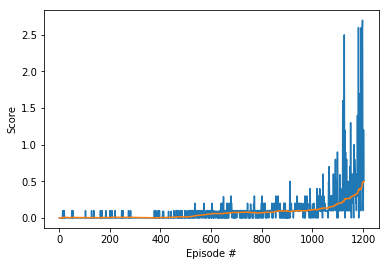

In [8]:
#Use active_session() on Udacity workspace
from workspace_utils import active_session

with active_session():
    # do long-running work here
    scores, scores_avg = MADDPG_Training()
    with open("scores_file.json", "w") as write_file:
        json.dump((scores, scores_avg), write_file)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.plot(np.arange(1, len(scores)+1), scores_avg)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

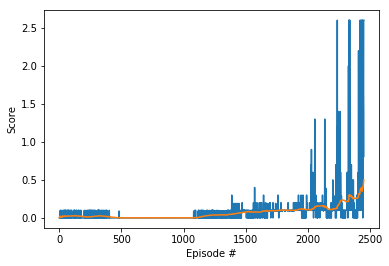

In [8]:
#plot scores
with open("scores_file.json", "r") as read_file:
    scores, scores_avg = json.load(read_file)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
#Inference
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seeding()
state_size=env_info.vector_observations.shape[1]
action_size=brain.vector_action_space_size
num_agents=env_info.vector_observations.shape[0]
MADDPG_obj = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents)
MADDPG_obj.load_maddpg() #load the local network weights

scores_list = []
def MADDPG_Inference(n_episodes=3, t_max=1000):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        MADDPG_obj.reset() #reset the MADDPG_obj OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent in MADDPG_obj)
        for _ in range(t_max):
            actions = MADDPG_obj.act(states, i_episode=0, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent in MADDPG_obj)
            rewards = env_info.rewards                         # get rewards (for each agent in MADDPG_obj)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent in MADDPG_obj)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, scores))
        scores_list.append(np.max(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))

MADDPG_Inference()

Episode 1: [1.00000001 0.99000002]
Episode 2: [1.49000002 1.50000002]
Episode 3: [0.50000001 0.49000001]
Mean score is:  1.0000000149011612


In [10]:
env.close()